In [1]:
#https://www.pyimagesearch.com/2019/01/21/regression-with-keras/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical CPU, 1 Logical CPU


In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

In [3]:
def load_house_attributes(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)

	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()

	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)

	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])

	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoing, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])

	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])

	# return the concatenated training and testing data
	return (trainX, testX)

In [4]:
def create_mlp(dim, regress=False):
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))

	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))

	# return our model
	return model

In [5]:
# import the necessary packages
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import locale

In [8]:
# +Add data before loading

!wget -O gdrivedl 'https://f.mjh.nz/gdrivedl'
!ls -l
!pwd

"""
!bash /kaggle/working/gdrivedl https://drive.google.com/file/d/1LOiv7EyZspaKSWYiaKjUi81fr0Dqp0Si/view?usp=sharing
!ls -l /kaggle/working
inputdir = "/kaggle/working"
"""

!bash /content/gdrivedl https://drive.google.com/file/d/1LOiv7EyZspaKSWYiaKjUi81fr0Dqp0Si/view?usp=sharing
!ls -l /content
inputdir = "/content"

--2020-12-12 22:28:30--  https://f.mjh.nz/gdrivedl
Resolving f.mjh.nz (f.mjh.nz)... 104.28.31.233, 172.67.162.157, 104.28.30.233, ...
Connecting to f.mjh.nz (f.mjh.nz)|104.28.31.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362 (1.3K) [application/octet-stream]
Saving to: ‘gdrivedl’

gdrivedl            100%[===================>]   1.33K  --.-KB/s    in 0s      

2020-12-12 22:28:30 (14.2 MB/s) - ‘gdrivedl’ saved [1362/1362]

total 12
-rw-r--r-- 1 root root 1362 Jan 29  2019 gdrivedl
-rw-r--r-- 1 root root 3261 Dec 12 22:28 google_drive.file
drwxr-xr-x 1 root root 4096 Dec  2 22:04 sample_data
/content
File ID: 1LOiv7EyZspaKSWYiaKjUi81fr0Dqp0Si
Downloading: https://docs.google.com/uc?export=download&id=1LOiv7EyZspaKSWYiaKjUi81fr0Dqp0Si > .111.file
Downloading: https://docs.google.com/uc?export=download&id=1LOiv7EyZspaKSWYiaKjUi81fr0Dqp0Si&confirm=GbhJ > .111.file
Moving: .111.file > Houses_Dataset.zip
Saved: Houses_Dataset.zip
DONE!
total 181660
-rw-r--

In [9]:
# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading house attributes...")
#inputPath = os.path.sep.join(['Houses_Dataset', "HousesInfo.txt"])
import zipfile
zf = zipfile.ZipFile(os.path.join(inputdir, 'Houses_Dataset.zip'))
inputfile = zf.open('HousesInfo.txt')
#df = load_house_attributes(inputPath)
df = load_house_attributes(inputfile)

[INFO] loading house attributes...


In [10]:
# construct a training and testing split with 75% of the data used
# for training and the remaining 25% for evaluation
print("[INFO] constructing training/testing split...")
(train, test) = train_test_split(df, test_size=0.25, random_state=42)

[INFO] constructing training/testing split...


In [11]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (this will lead to
# better training and convergence)
maxPrice = train["price"].max()
trainY = train["price"] / maxPrice
testY = test["price"] / maxPrice

In [12]:
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
print("[INFO] processing data...")
(trainX, testX) = process_house_attributes(df, train, test)

[INFO] processing data...


In [13]:
# create our MLP and then compile the model using mean absolute
# percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions*
# and the *actual prices*
model = create_mlp(trainX.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train the model
print("[INFO] training model...")
history = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=200, batch_size=8, verbose=1)

[INFO] training model...
Epoch 1/200
34/34 [==============================] - 0s 5ms/step - loss: 70.0133 - val_loss: 57.1280
Epoch 2/200
34/34 [==============================] - 0s 1ms/step - loss: 50.3408 - val_loss: 42.8583
Epoch 3/200
34/34 [==============================] - 0s 2ms/step - loss: 42.5020 - val_loss: 36.8944
Epoch 4/200
34/34 [==============================] - 0s 2ms/step - loss: 39.9217 - val_loss: 36.1380
Epoch 5/200
34/34 [==============================] - 0s 2ms/step - loss: 38.2650 - val_loss: 35.5050
Epoch 6/200
34/34 [==============================] - 0s 2ms/step - loss: 36.7163 - val_loss: 36.9688
Epoch 7/200
34/34 [==============================] - 0s 2ms/step - loss: 35.9258 - val_loss: 31.4209
Epoch 8/200
34/34 [==============================] - 0s 2ms/step - loss: 32.7223 - val_loss: 27.6826
Epoch 9/200
34/34 [==============================] - 0s 2ms/step - loss: 31.2799 - val_loss: 29.2924
Epoch 10/200
34/34 [==============================] - 0s 2ms/step 

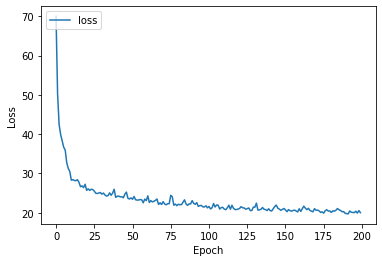

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

In [17]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(testX)

[INFO] predicting house prices...


In [18]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [20]:
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [21]:
# finally, show some statistics on our model
#locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
#print("[INFO] avg. house price: {}, std house price: {}".format(
#	locale.currency(df["price"].mean(), grouping=True),
#	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] mean: 22.66%, std: 17.96%
